In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from structureboost import log_loss
pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)

# Add Lineup to Model
- Last time we scraped individual batter data for the 6400+ players who have appeared in a starting lineup between 1980 and 2022.
- We then processed the data to get statistics about the trailing performance of each of the players before each game in which they started.
- Using this, we were able to get features related to each player that could be used to predict each game. We then averaged across the lineup in several different ways to come up with a variety of lineup related statistics.


Now, we will add these features to the model and see how much improvement we get

In [3]:
df=pd.read_csv('Data/df_bp9.csv')

/tmp/ipykernel_112931/623349023.py:1: DtypeWarning: Columns (13,14,15,19,85,87,159,198) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('Data/df_bp9.csv')


In [4]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1980) & (df.season<=2018) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2019) & (df.season<=2020)]
df_test = df[df.season>=2021]
df_test_val = df[df.season>=2019]
df.shape

(96215, 1235)

In [6]:
hv_mean = df_train.home_victory.mean()

In [7]:
target = 'home_victory'

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()

In [8]:
def try_features(feat_set, max_depth=2):
    target = 'home_victory'
    X_train = df_train.loc[:,feat_set]
    X_valid = df_valid.loc[:,feat_set]
    X_test = df_test.loc[:,feat_set]



    lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=max_depth)
    lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50)])
    
    preds_lgbm_test = lgbm1.predict_proba(X_test)[:,1]
    ll_test = log_loss(y_test, preds_lgbm_test)

    print(f'\nVegas probs: {log_loss(y_test,df_test.implied_prob_h_mid)} on test')
    print(f'model probs: {ll_test} on test')

    print(f'\nDifference: {ll_test - log_loss(y_test,df_test.implied_prob_h_mid)} on test')

    sv_lgbm = lgbm1.predict(X_test, pred_contrib=True)
    sv_lgbm = pd.DataFrame(sv_lgbm)
    sv_lgbm.columns = list(X_test.columns)+['Intercept']
    sv_vec = sv_lgbm.abs().mean().sort_values(ascending=False)
    print('\nAvg Shap Vals')
    
    print(sv_vec)
    out_dict={}
    out_dict['ll_test'] = ll_test
    out_dict['model'] = lgbm1
    out_dict['shap_val_avgs'] = sv_vec
    out_dict['preds_test'] = preds_lgbm_test
    return(out_dict)

In [9]:
features0 = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v',
            'Strt_WHIP_35_h','Strt_WHIP_35_v',
            'Strt_TB_BB_perc_35_h', 'Strt_TB_BB_perc_35_v',
            'Strt_H_BB_perc_35_h', 'Strt_H_BB_perc_35_v',
            'Strt_SO_perc_10_h', 'Strt_SO_perc_10_v',
            'Bpen_WHIP_75_h','Bpen_WHIP_75_v',
            'Bpen_TB_BB_perc_75_h', 'Bpen_TB_BB_perc_75_v',
            'Bpen_H_BB_perc_75_h', 'Bpen_H_BB_perc_75_v',
            'Bpen_SO_perc_75_h', 'Bpen_SO_perc_75_v',
            'Bpen_WHIP_35_h','Bpen_WHIP_35_v',
            'Bpen_TB_BB_perc_35_h', 'Bpen_TB_BB_perc_35_v',
            'Bpen_H_BB_perc_35_h', 'Bpen_H_BB_perc_35_v',
            'Bpen_SO_perc_35_h', 'Bpen_SO_perc_35_v',
            'Bpen_WHIP_10_h','Bpen_WHIP_10_v',
            'Bpen_TB_BB_perc_10_h', 'Bpen_TB_BB_perc_10_v',
            'Bpen_H_BB_perc_10_h', 'Bpen_H_BB_perc_10_v',
            'Bpen_SO_perc_10_h', 'Bpen_SO_perc_10_v']

In [10]:
d0 = try_features(features0)

[LightGBM] [Info] Number of positive: 46023, number of negative: 39337
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9180
[LightGBM] [Info] Number of data points in the train set: 85360, number of used features: 36
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539164 -> initscore=0.156976
[LightGBM] [Info] Start training from score 0.156976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[603]	valid_0's binary_logloss: 0.672806

Vegas probs: 0.6675629431340582 on test
model probs: 0.6714934504802158 on test

Difference: 0.00393050734615763 on test

Avg Shap Vals
Intercept               0.159327
Strt_SO_perc_10_h       0.079810
Strt_SO_perc_10_v       0.079673
OBP_162_v               0.062744
Strt_WHIP_35_v          0.053249
Strt_WHIP_35_h          0.052227
OBP_162_h               0.049028


In [11]:
f_lineup_a = [
            'lineup9_OBP_162_h','lineup9_OBP_162_v',
            'lineup9_SLG_162_h','lineup9_SLG_162_v',
]

features1 = features0 + f_lineup_a


In [12]:
d1 = try_features(features1)

[LightGBM] [Info] Number of positive: 46023, number of negative: 39337
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 85360, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539164 -> initscore=0.156976
[LightGBM] [Info] Start training from score 0.156976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[638]	valid_0's binary_logloss: 0.672435

Vegas probs: 0.6675629431340582 on test
model probs: 0.6705352971803024 on test

Difference: 0.0029723540462441855 on test

Avg Shap Vals
Intercept               0.159555
Strt_SO_perc_10_v       0.078905
Strt_SO_perc_10_h       0.076724
Strt_WHIP_35_h          0.049814
Strt_WHIP_35_v          0.049799
lineup9_SLG_162_v       0.046246
OBP_162_v               0.0461

# let's use the individual batters instead

In [14]:
slg_indiv_cols = [x for x in df.columns if '_b' in x and 'SLG_162' in x]
obp_indiv_cols = [x for x in df.columns if '_b' in x and 'OBP_162' in x]

In [21]:
features2 = features0 + slg_indiv_cols + obp_indiv_cols
d2 = try_features(features2, max_depth=2)

[LightGBM] [Info] Number of positive: 46023, number of negative: 39337
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18360
[LightGBM] [Info] Number of data points in the train set: 85360, number of used features: 72
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539164 -> initscore=0.156976
[LightGBM] [Info] Start training from score 0.156976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[796]	valid_0's binary_logloss: 0.672782

Vegas probs: 0.6675629431340582 on test
model probs: 0.6709353210174647 on test

Difference: 0.0033723778834064966 on test

Avg Shap Vals
Intercept               0.159590
Strt_SO_perc_10_h       0.077401
Strt_SO_perc_10_v       0.075277
Strt_WHIP_35_v          0.051338
Strt_WHIP_35_h          0.050682
OBP_162_v               0.034845
Strt_TB_BB_perc_35_h    0.0323

In [16]:
features3 = features0 + slg_indiv_cols + obp_indiv_cols + f_lineup_a
d3 = try_features(features3)

[LightGBM] [Info] Number of positive: 46023, number of negative: 39337
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19380
[LightGBM] [Info] Number of data points in the train set: 85360, number of used features: 76
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539164 -> initscore=0.156976
[LightGBM] [Info] Start training from score 0.156976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[682]	valid_0's binary_logloss: 0.673246

Vegas probs: 0.6675629431340582 on test
model probs: 0.6707024876736312 on test

Difference: 0.0031395445395729915 on test

Avg Shap Vals
Intercept               0.159591
Strt_SO_perc_10_v       0.075456
Strt_SO_perc_10_h       0.074175
Strt_WHIP_35_v          0.049813
Strt_WHIP_35_h          0.049416
lineup9_SLG_162_v       0.036923
lineup9_OBP_162_h       0.0340

In [17]:
f_lineup_b =  [
            'lineup9_OBS_162_h','lineup9_OBS_162_v',
            'lineup9_SLGmod_162_h','lineup9_SLGmod_162_v',
            'lineup9_SObat_perc_162_h','lineup9_SObat_perc_162_v',
]
features4 = features0  +f_lineup_a + f_lineup_b
d4 = try_features(features4)

[LightGBM] [Info] Number of positive: 46023, number of negative: 39337
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11730
[LightGBM] [Info] Number of data points in the train set: 85360, number of used features: 46
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539164 -> initscore=0.156976
[LightGBM] [Info] Start training from score 0.156976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[623]	valid_0's binary_logloss: 0.672366

Vegas probs: 0.6675629431340582 on test
model probs: 0.6708940129178201 on test

Difference: 0.003331069783761964 on test

Avg Shap Vals
Intercept                   0.159527
Strt_SO_perc_10_v           0.077992
Strt_SO_perc_10_h           0.074549
Strt_WHIP_35_h              0.050565
Strt_WHIP_35_v              0.049127
OBP_162_v                   0.044349
Strt_TB

In [18]:
f_lineup_a_w =  [
            'lineup9_OBP_162_w_h','lineup9_OBP_162_w_v',
            'lineup9_SLG_162_w_h','lineup9_SLG_162_w_v',
]
features5 = features0+f_lineup_a_w
d5 = try_features(features5)

[LightGBM] [Info] Number of positive: 46023, number of negative: 39337
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 85360, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539164 -> initscore=0.156976
[LightGBM] [Info] Start training from score 0.156976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[600]	valid_0's binary_logloss: 0.672809

Vegas probs: 0.6675629431340582 on test
model probs: 0.6706923517627169 on test

Difference: 0.0031294086286587364 on test

Avg Shap Vals
Intercept               0.159474
Strt_SO_perc_10_v       0.077399
Strt_SO_perc_10_h       0.075030
Strt_WHIP_35_h          0.050404
Strt_WHIP_35_v          0.049398
lineup9_SLG_162_w_v     0.045528
OBP_162_v               0.0436

In [19]:
f_lineup_a_8 =  [
            'lineup8_OBP_162_w_h','lineup8_OBP_162_w_v',
            'lineup8_SLG_162_w_h','lineup8_SLG_162_w_v',
]
features6 = features0+f_lineup_a_8
d6 = try_features(features6)


[LightGBM] [Info] Number of positive: 46023, number of negative: 39337
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10200
[LightGBM] [Info] Number of data points in the train set: 85360, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539164 -> initscore=0.156976
[LightGBM] [Info] Start training from score 0.156976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[692]	valid_0's binary_logloss: 0.672222

Vegas probs: 0.6675629431340582 on test
model probs: 0.6708831364548522 on test

Difference: 0.0033201933207940293 on test

Avg Shap Vals
Intercept               0.159653
Strt_SO_perc_10_v       0.079157
Strt_SO_perc_10_h       0.078095
Strt_WHIP_35_h          0.051509
Strt_WHIP_35_v          0.049820
OBP_162_v               0.043097
lineup8_SLG_162_w_v     0.0417

In [22]:
f_lineup_c = [
            'lineup9_OBP_350_h','lineup9_OBP_350_v',
            'lineup9_SLG_350_h','lineup9_SLG_350_v',
]

f_lineup_d = [
            'lineup9_OBP_75_h','lineup9_OBP_75_v',
            'lineup9_SLG_75_h','lineup9_SLG_75_v',
]
features7 = features0 + f_lineup_a + f_lineup_c+ f_lineup_d
d7 = try_features(features7, max_depth=2)

[LightGBM] [Info] Number of positive: 46023, number of negative: 39337
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 85360, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539164 -> initscore=0.156976
[LightGBM] [Info] Start training from score 0.156976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[711]	valid_0's binary_logloss: 0.671724

Vegas probs: 0.6675629431340582 on test
model probs: 0.6708389917475919 on test

Difference: 0.0032760486135336997 on test

Avg Shap Vals
Intercept               0.159720
Strt_SO_perc_10_v       0.079459
Strt_SO_perc_10_h       0.078243
Strt_WHIP_35_h          0.049559
Strt_WHIP_35_v          0.047634
OBP_162_v               0.042887
Strt_TB_BB_perc_35_h    0.0377

In [23]:
f_simple = ['OBP_162_h','OBP_162_v',
            'SLG_162_h','SLG_162_v']

features8 = f_simple
d8 = try_features(features8, max_depth=2)

[LightGBM] [Info] Number of positive: 46023, number of negative: 39337
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 85360, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539164 -> initscore=0.156976
[LightGBM] [Info] Start training from score 0.156976
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[387]	valid_0's binary_logloss: 0.680537

Vegas probs: 0.6675629431340582 on test
model probs: 0.6826330119526713 on test

Difference: 0.01507006881861317 on test

Avg Shap Vals
Intercept    0.158083
OBP_162_v    0.091542
OBP_162_h    0.083872
SLG_162_h    0.050312
SLG_162_v    0.041161
dtype: float64


# Model Analysis

- Is there any other evidence that this last enhancement "improved" the model?
- LV model is still better overall, but are we "adding any value"? Is our model "catching" anything they are not?

In [24]:
discreps_lv0 = (d0['preds_test']-df_test.implied_prob_h_mid).to_numpy() # Without lineup features
discreps_lv1 = (d1['preds_test']-df_test.implied_prob_h_mid).to_numpy() # With lineup features

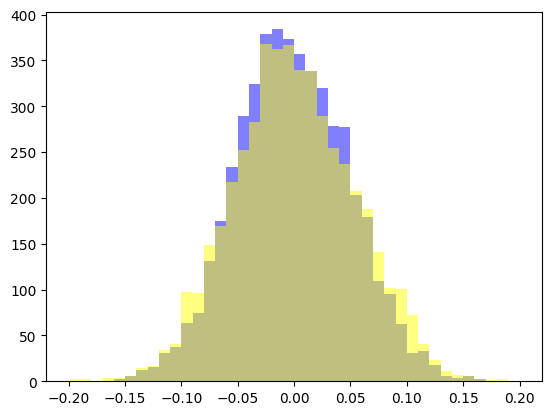

In [25]:
plt.hist(discreps_lv1, bins=np.linspace(-.2,.2,41), alpha=.5, color='blue');
plt.hist(discreps_lv0, bins=np.linspace(-.2,.2,41), alpha=.5, color='yellow');

In [26]:
np.mean(np.abs(discreps_lv1)), np.mean(np.abs(discreps_lv0))

(0.039928205954805084, 0.04331229062145613)

In [27]:
weak_model_preds = d8['preds_test']
strong_model_preds = d1['preds_test']

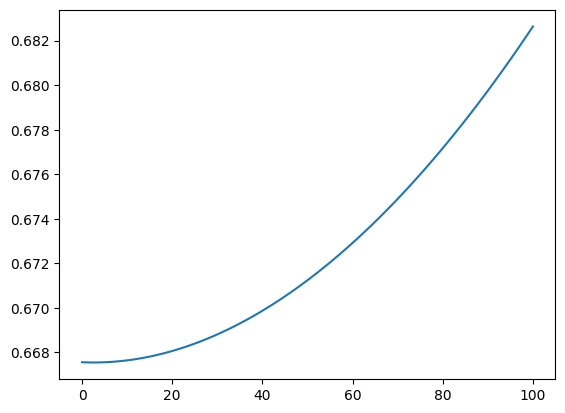

In [28]:
## Mixing in our first (very simple) model
ll_mix_vec_weak = [log_loss(y_test, (k*weak_model_preds+(1-k)*df_test.implied_prob_h_mid)) for k in np.linspace(0,1,101)]
plt.plot(ll_mix_vec_weak)

In [29]:
ll_mix_vec_weak[0] - np.min(ll_mix_vec_weak), np.argmin(ll_mix_vec_weak)

(1.0983347986881498e-05, 3)

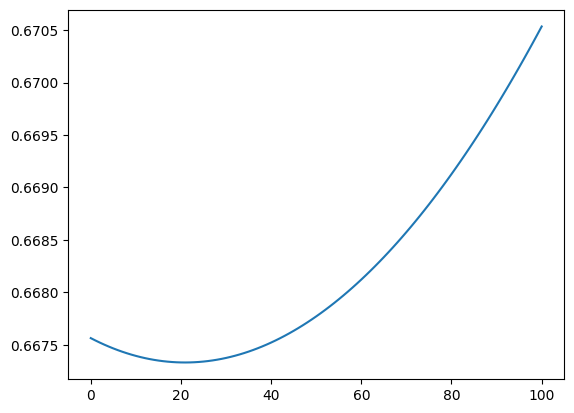

In [30]:
## Mixing in our latest model
ll_mix_vec_strong = [log_loss(y_test, (k*strong_model_preds+(1-k)*df_test.implied_prob_h_mid)) for k in np.linspace(0,1,101)]
plt.plot(ll_mix_vec_strong)

In [31]:
ll_mix_vec_strong[0] - np.min(ll_mix_vec_strong), np.argmin(ll_mix_vec_strong)

(0.00023233442797521153, 21)

In [32]:
# Simulate different model variations on a single test set
# Gives a sense of how much different models (each with the same quality) will vary
def ll_model_discrep_shuffle(probvec_true, discreps, num_trials, answers):
    # sim_outcome = np.random.binomial(n=1, p=probvec_true)
    llvec_mod = np.zeros(num_trials)
    discr1 = discreps.copy()
    for i in range(num_trials):
        np.random.shuffle(discr1)
        pv_mod = pv_true  + discr1
        llvec_mod[i] = log_loss(answers, pv_mod)
    return(llvec_mod)

In [33]:
pv_true = df_test.implied_prob_h_mid
losses = ll_model_discrep_shuffle(pv_true, discreps_lv1, 10000, y_test)

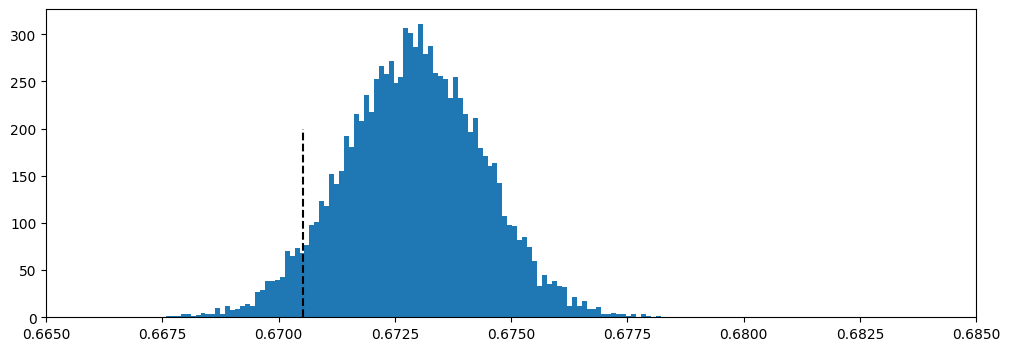

In [34]:
plt.figure(figsize=(12,4))
plt.hist(losses, bins=100);
plt.xlim([.665,.685]);
plt.vlines(x=log_loss(y_test, strong_model_preds), ymin=0, ymax=200, color='k', linestyle='--')

# Conclusions
- We went from ~40bps to ~30bps by adding lineup variables OBS, SLG (for home and away)
- Changing variants, adding more variables did not seem to improve at all
- Vegas model is still better overall, but evidence that our model captures effects that they don't


# Next Steps

- model runs scored
  - That will help predict the O/U
  - May help predict winner of game
  - Use probablistic regression to get a distribution on runs scored instead of a point estimate